In [1]:
from nd2tif.transform import to_8bits
from api import read

In [2]:
from nd2_combine import tools
from segment import seg
from droplet_growth import multiwell
import numpy as np
import logging
import os
import math
from skimage.transform import rotate
import json
from glob import glob
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d as gf
import pandas as pd
import seaborn as sns
from functools import partial

logging.basicConfig(level=logging.DEBUG)

logger = logging.getLogger()
%load_ext autoreload
%autoreload 2

In [3]:
PX_SIZE_UM = 1.6

In [5]:
fluo_path = '/home/aaristov/Multicell/Sebastien/mESC_aggregates/SUMO//Stacks_AggreWell_D3/'
assert os.path.exists(fluo_path)

In [6]:
def segment_bf(well, thr=0.2, smooth=10, erode=10, fill=True, plot=False):
    '''
    Serments input 2d array using thresholded gradient with filling
    Returns SegmentedImage object
    '''
    grad = multiwell.get_2d_gradient(well)
    sm = multiwell.gaussian_filter(grad, smooth)
#     sm = multiwell.gaussian_filter(well, smooth)
    
    regions = sm > thr * sm.max()
    
    if fill:
        regions = multiwell.binary_fill_holes(regions)
    
    if erode:
        regions = multiwell.binary_erosion(regions, iterations=erode)
    
    labels, n_labels = multiwell.label(regions)
    print(f'{n_labels} region{" s"[n_labels>1]}')
    if plot:
        fig, ax = multiwell.plt.subplots(1,2)
        ax[0].imshow(sm, cmap='gray')
        ax[1].imshow(labels)
        multiwell.plt.show()
        
    return labels

def subsample_intensity_profile(values, n_samples=10, sigma=10, plot=False):
    '''
    Subsamples 1D curve.
    1. Cut off zero values
    2. Smooth with `sigma`
    3. Intepolate using vector with `n_samples` spots
    
    Return:
    -------
    Subsampled values
    '''
    r_profile = np.array(values, 'float')
    rf_profile = r_profile[r_profile > 0]
    rfs_profile = gf(rf_profile, sigma)
    full_vector = np.arange(len(rfs_profile))
    approx = interp1d(full_vector, rfs_profile)
    vector = np.linspace(0, len(rfs_profile)-1, n_samples, endpoint=True)
    subsample = approx(vector)
    
    if plot:
        plt.plot(rf_profile)
        plt.plot(rfs_profile)
        plt.plot(vector, subsample, '.r')
    
    return subsample

def orient(curve):
    curve = curve / curve.max()
    mid = len(curve) // 2
    if curve.argmax() < mid:
        return curve[::-1]
    else:
        return curve

In [7]:
def process_2_colors(stack:dict, min_size=200, bins=20, axis=0):
    '''
    axis = 0: profile along major axis
    axis = 1: profile along minor axis
    '''
    path, stack = stack.values()
    dapi, bra = stack
    labels = segment_bf(dapi, plot=1)
    props = multiwell.regionprops(labels, intensity_image=bra)
    profiles = pd.DataFrame()
    prop_index=0
    for p in props:
        if (mal := p.major_axis_length) > min_size:
            crop = p.intensity_image
            
            print(f'good size {mal} ')
            prop_index += 1
            aligned = rotate(
                crop,
                -p.orientation / math.pi * 180 - 90,
                resize=True
            )
            multiwell.show(aligned)
            multiwell.plt.show()
            profile = aligned.max(axis=axis)
            binned_profile = subsample_intensity_profile(profile, bins)
            oriented_binned_profile = orient(binned_profile)
            vector = np.linspace(-.5, .5, bins)
            profiles = profiles.append(
                pd.DataFrame(
                    data={
                        'max_intensity': oriented_binned_profile, 
                        'bins': vector, 
                        'path': path, 
                        'size_px': mal,
                        'organoid': prop_index
                    }
                )
            )
        else:
            print(f'size too small {mal} < {min_size}')
    return profiles

In [8]:
reader = list(map(lambda path: {'path': path, 'data': read.virtual_stack.imread(path)}, glob(fluo_path + '*.tif')))


1 region 


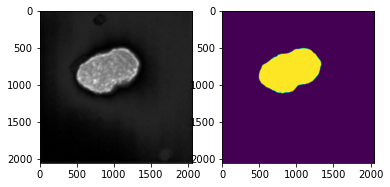

good size 865.5097942493722 


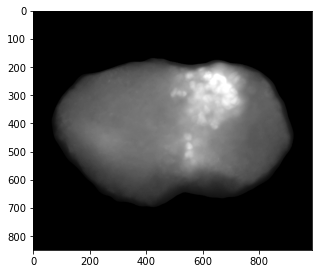

1 region 


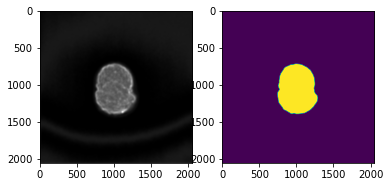

good size 693.8708638612675 


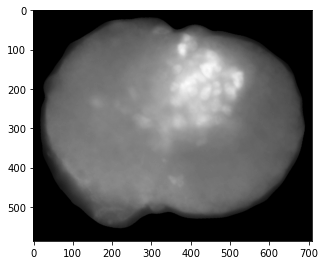

14 regions


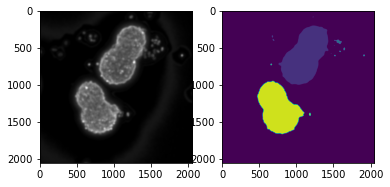

size too small 23.83258218847756 < 200
good size 904.9443592500361 


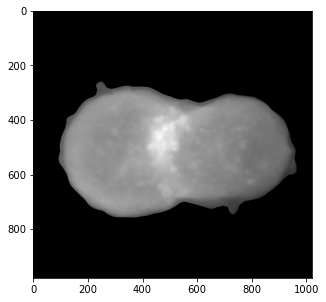

size too small 29.731622563372763 < 200
size too small 29.64911409154094 < 200
size too small 93.69577914585021 < 200
size too small 7.811725553869513 < 200
size too small 34.80965302100378 < 200
size too small 21.801563648242517 < 200
size too small 9.761305741962364 < 200
size too small 20.07263333232866 < 200
size too small 15.94599875181689 < 200
size too small 19.793589037247823 < 200
good size 757.7180581252777 


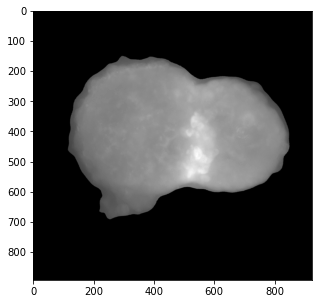

size too small 38.70001459430714 < 200
1 region 


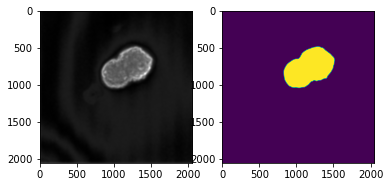

good size 742.0594213910871 


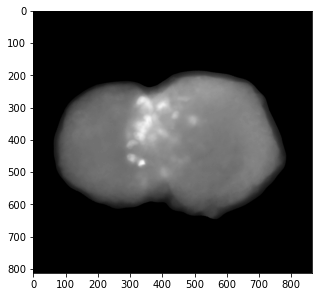

2 regions


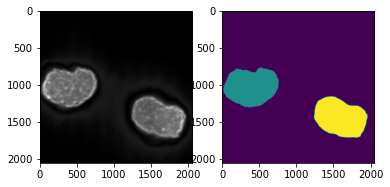

good size 751.9478096967053 


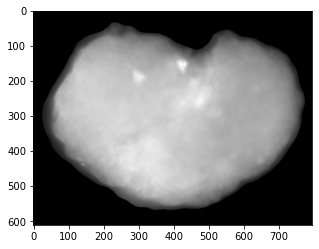

good size 762.6628885915079 


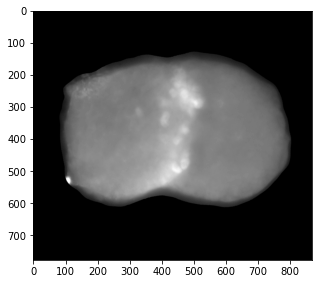

1 region 


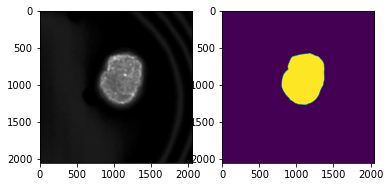

good size 709.9341184543206 


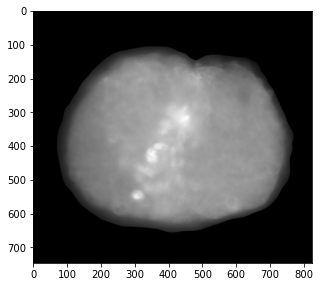

1 region 


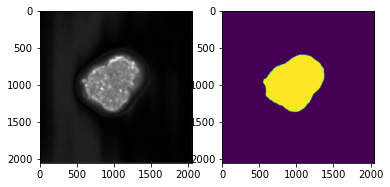

good size 841.3306737604861 


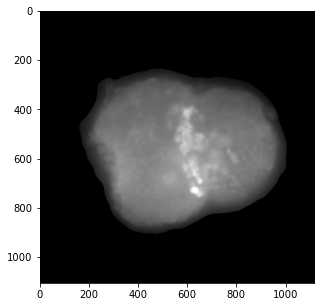

1 region 


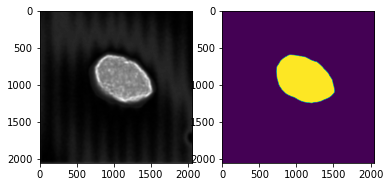

good size 828.9293598325208 


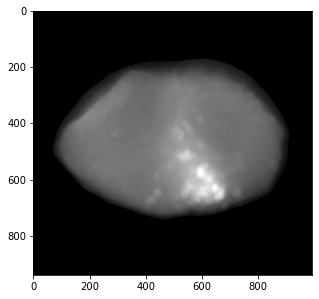

1 region 


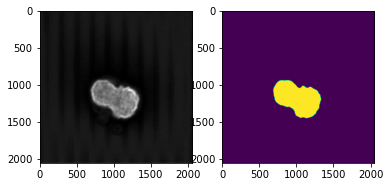

good size 710.0182739926768 


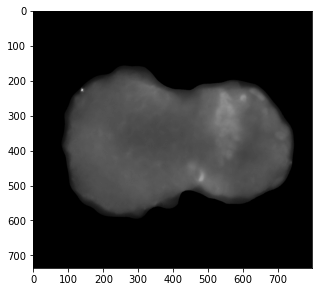

1 region 


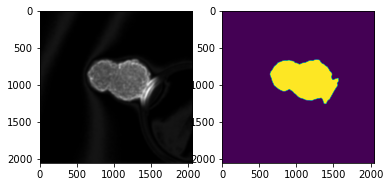

good size 928.7577098448768 


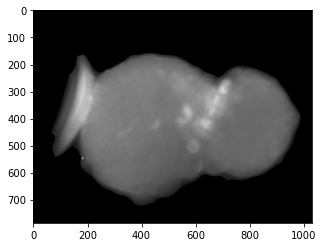

1 region 


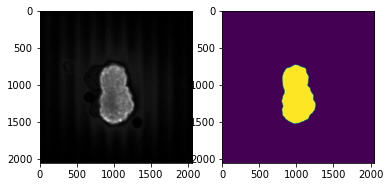

good size 819.1387840510627 


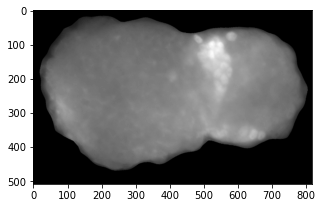

1 region 


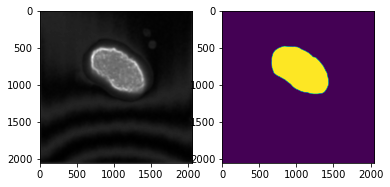

good size 871.2004785483298 


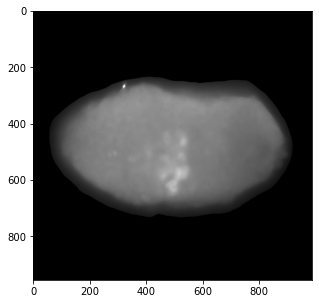

In [9]:
profiles = list(map(process_2_colors, reader))

1 region 


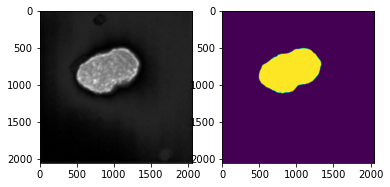

good size 865.5097942493722 


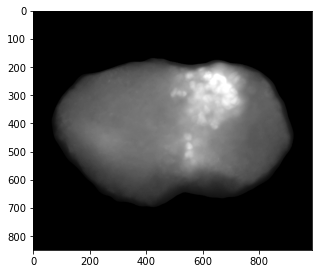

1 region 


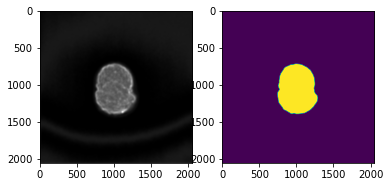

good size 693.8708638612675 


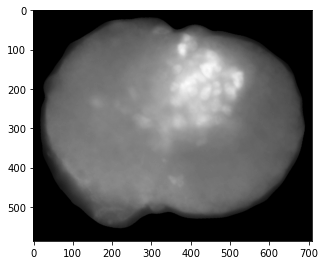

14 regions


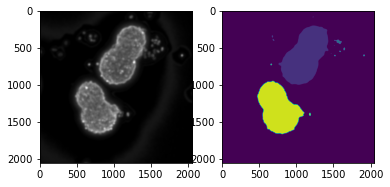

size too small 23.83258218847756 < 200
good size 904.9443592500361 


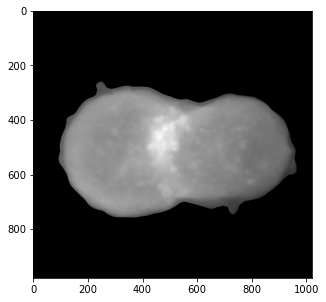

size too small 29.731622563372763 < 200
size too small 29.64911409154094 < 200
size too small 93.69577914585021 < 200
size too small 7.811725553869513 < 200
size too small 34.80965302100378 < 200
size too small 21.801563648242517 < 200
size too small 9.761305741962364 < 200
size too small 20.07263333232866 < 200
size too small 15.94599875181689 < 200
size too small 19.793589037247823 < 200
good size 757.7180581252777 


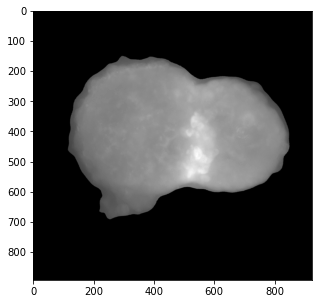

size too small 38.70001459430714 < 200
1 region 


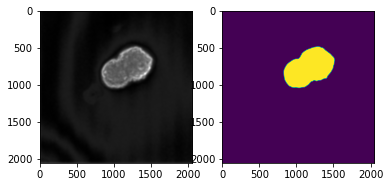

good size 742.0594213910871 


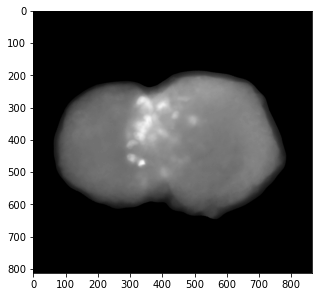

2 regions


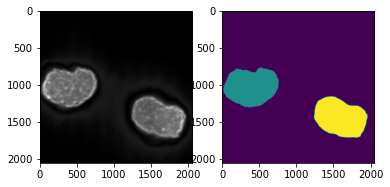

good size 751.9478096967053 


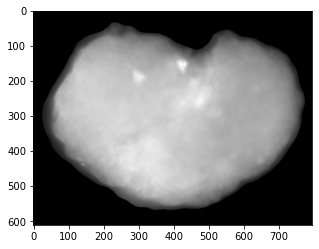

good size 762.6628885915079 


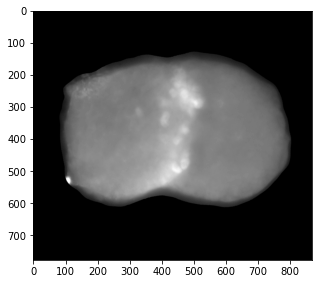

1 region 


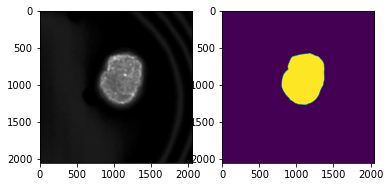

good size 709.9341184543206 


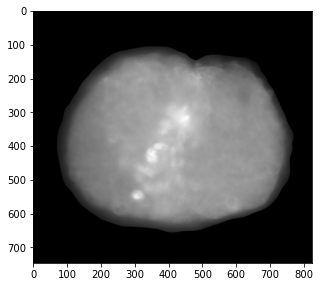

1 region 


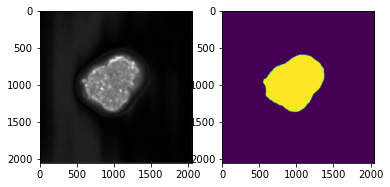

good size 841.3306737604861 


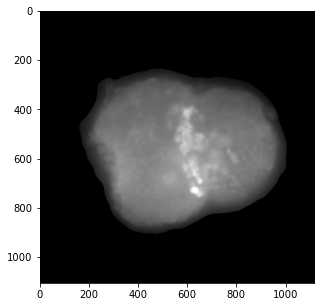

1 region 


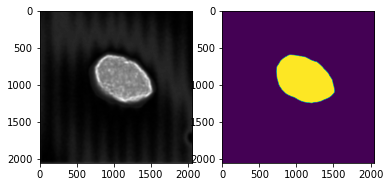

good size 828.9293598325208 


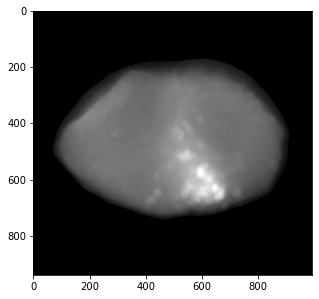

1 region 


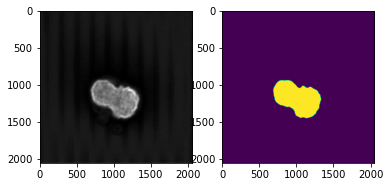

good size 710.0182739926768 


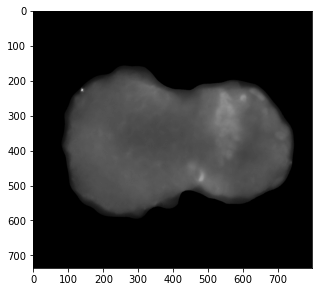

1 region 


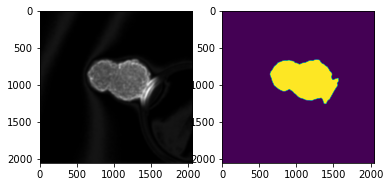

good size 928.7577098448768 


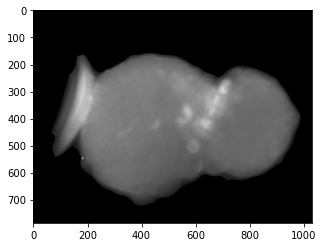

1 region 


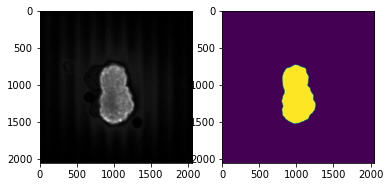

good size 819.1387840510627 


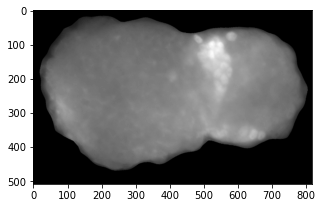

1 region 


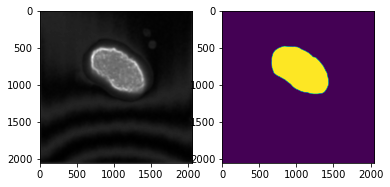

good size 871.2004785483298 


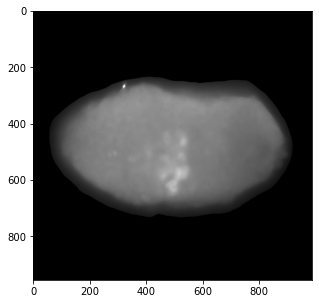

In [10]:
cross_profiles = list(map(partial(process_2_colors, axis=1), reader))

In [17]:
pd.concat(profiles).to_csv(os.path.join(fluo_path, 'profiles.csv'))
pd.concat(cross_profiles).to_csv(os.path.join(fluo_path, 'cross_profiles.csv'))


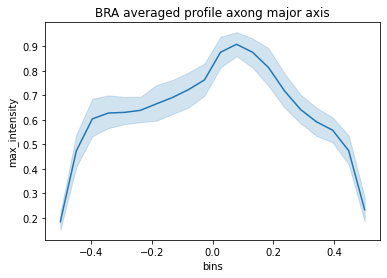

In [13]:
sns.lineplot(data=pd.concat(profiles), x='bins', y='max_intensity')
plt.title('BRA averaged profile axong major axis')
plt.savefig(os.path.join(fluo_path, 'major_axis_proofile.pdf'))

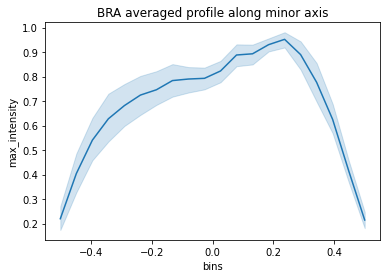

In [14]:
sns.lineplot(data=pd.concat(cross_profiles), x='bins', y='max_intensity')
plt.title('BRA averaged profile along minor axis')
plt.savefig(os.path.join(fluo_path, 'minor_axis_profile.pdf'))